# STPB_LSTM_WITH_CLASS

In [2387]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2388]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)
sys.path.append('C:\git\statslib')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [2389]:
import statsmodels.api as sm
import statslib as stb
import tensorflow as tf
import seaborn as sns

In [2390]:
import numpy as np
from datetime import datetime, date
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
from copy import deepcopy
from pandas.tseries.offsets import DateOffset

In [2391]:
from gmt.fom.gas.shared.utils.common import *
from gmt.fom.gas.shared.utils.dframe import *

In [2392]:
from gmt.fom.gas.shared.models.short_term_power_burn.stpb import MongoAdapter

In [2393]:
figsize=(9*1.6, 9)

In [2394]:
def save_to_path(f_name):
    _path = r'C:/git/gmt-fom-gas-research/sandbox/alexs/short_term_power_burn'
    return os.path.join(_path, f_name + '.csv')

In [2395]:
def get_fourier_series(timeIndex,K):
    m = 7
    d = 1
    fourier_series = pd.DataFrame({'date':timeIndex})
    fourier_series = fourier_series.set_index(pd.RangeIndex(1,len(timeIndex)+1))

    for i in range(1, K+1):
        fourier_series[f'S{i}-{m}'] = np.sin(2 * i * np.pi * d *fourier_series.index/ m)
        fourier_series[f'C{i}-{m}'] = np.cos(2 * i * np.pi * d *fourier_series.index/ m)
    fourier_series = fourier_series.drop(columns=['date'])
    fourier_series.index = timeIndex
    return fourier_series

# CONSTANTS

In [2396]:
YEARS = 4

In [2397]:
FORECAST_HORIZON = 1; FORECAST_HORIZON

1

In [2398]:
INPUT_WIDTH = 100; INPUT_WIDTH 

100

# DATA

In [2399]:
myData = MongoAdapter()
data = myData.load_design_matrix()

In [2400]:
#<------- TRAIN --------- VALIDATION -------- TEST -------->

In [2401]:
train_up_to_idx = data.index.min() + DateOffset(years=YEARS)
train_idx = data.truncate(after=train_up_to_idx).index

In [2402]:
pred_idx = data[-(2*INPUT_WIDTH+FORECAST_HORIZON):-FORECAST_HORIZON].index

In [2403]:
out_t_idx = data[-FORECAST_HORIZON:].index

In [2404]:
val_idx = sorted(set(data.index).difference(set(train_idx).union(pred_idx).union(out_t_idx)))

In [2405]:
print(f'train_idx={len(train_idx)}\nval_idx={len(val_idx)}\npred_idx={len(pred_idx)}\nout_t_idx={len(out_t_idx)}')

train_idx=1462
val_idx=207
pred_idx=200
out_t_idx=1


In [2406]:
assert len(train_idx)+len(val_idx)+len(pred_idx)+len(out_t_idx)==data.shape[0]

In [2407]:
#Enrich for Design Matrix

In [2408]:
#fourier series
K = 3
data = data.join(get_fourier_series(data.index,K))

In [2409]:
dependent_var = ['gas']; dependent_var
covariates = ['clean_spreads', 'dark_spreads', 'precip', 'temperature', 'wind']
fourier_cols =  [k for k in data if k.startswith('S') or k.startswith('C')]

In [2410]:
y = data[dependent_var]; f = stb.transforms.identical();
gs = dict()
g1 = stb.transforms.identical();
gs.update(dict(zip(covariates, [g1]*len(covariates))))
g2 = stb.transforms.identical()
gs.update(dict(zip(fourier_cols, [g2]*len(fourier_cols))))
X = data[covariates  + fourier_cols ]; 

In [2411]:
DM = stb.DesignMatrix(y=y, X=X, f=f, gs=gs, add_const=False)

In [2412]:
train_df = DM.dm.loc[train_idx].drop('y', axis=1).rename(columns=DM.names)
val_df = DM.dm.loc[val_idx].drop('y', axis=1).rename(columns=DM.names)
pred_df =DM.dm.loc[pred_idx].drop('y', axis=1).rename(columns=DM.names)
out_df =DM.dm.loc[out_t_idx].drop('y', axis=1).rename(columns=DM.names)

In [2413]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
pred_df = (pred_df - train_mean) / train_std

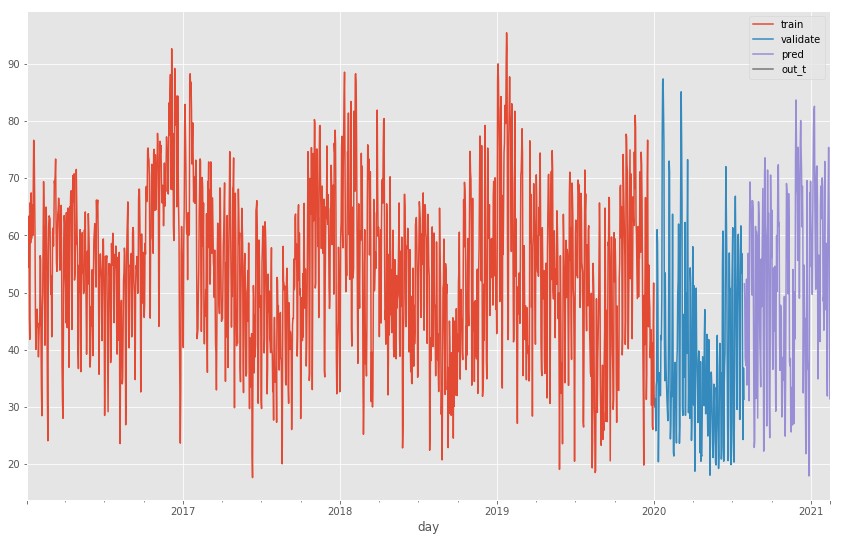

In [2414]:
fig, ax = plt.subplots(figsize=figsize)
DM.y.loc[train_idx].plot(ax=ax)
DM.y.loc[val_idx].plot(ax=ax)
DM.y.loc[pred_idx].plot(ax=ax)
DM.y.loc[out_t_idx].plot(ax=ax)
plt.legend(['train', 'validate', 'pred', 'out_t'])
plt.show()

# STANDARDIZATION OF FEATURES

In [2415]:
train_df.tail(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
day,,,,,,,,,,,,
2020-01-03,-1.697426,-0.271198,-1.159558,-0.518133,-0.679771,0.980831,-1.104921,0.882715,-1.377814,-0.313725,-0.613185,-1.273196


In [2416]:
val_df.head(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
t,,,,,,,,,,,,
2020-01-04,-1.599593,-0.271198,-1.159558,-0.764528,-0.753444,0.37391,5.872145e-14,1.415182,1.153151e-13,1.415182,-1.464933e-13,1.415182


In [2417]:
val_df.tail(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
t,,,,,,,,,,,,
2020-07-28,-1.60245,-0.080012,-1.842552,-0.736098,0.871137,1.280018,0.613185,-1.273196,-1.104921,0.882715,1.377814,-0.313725


In [2418]:
pred_df.head(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
day,,,,,,,,,,,,
2020-07-29,-0.163951,-0.080012,-1.842552,-0.650807,0.878693,-0.2843,-0.613185,-1.273196,1.104921,0.882715,-1.377814,-0.313725


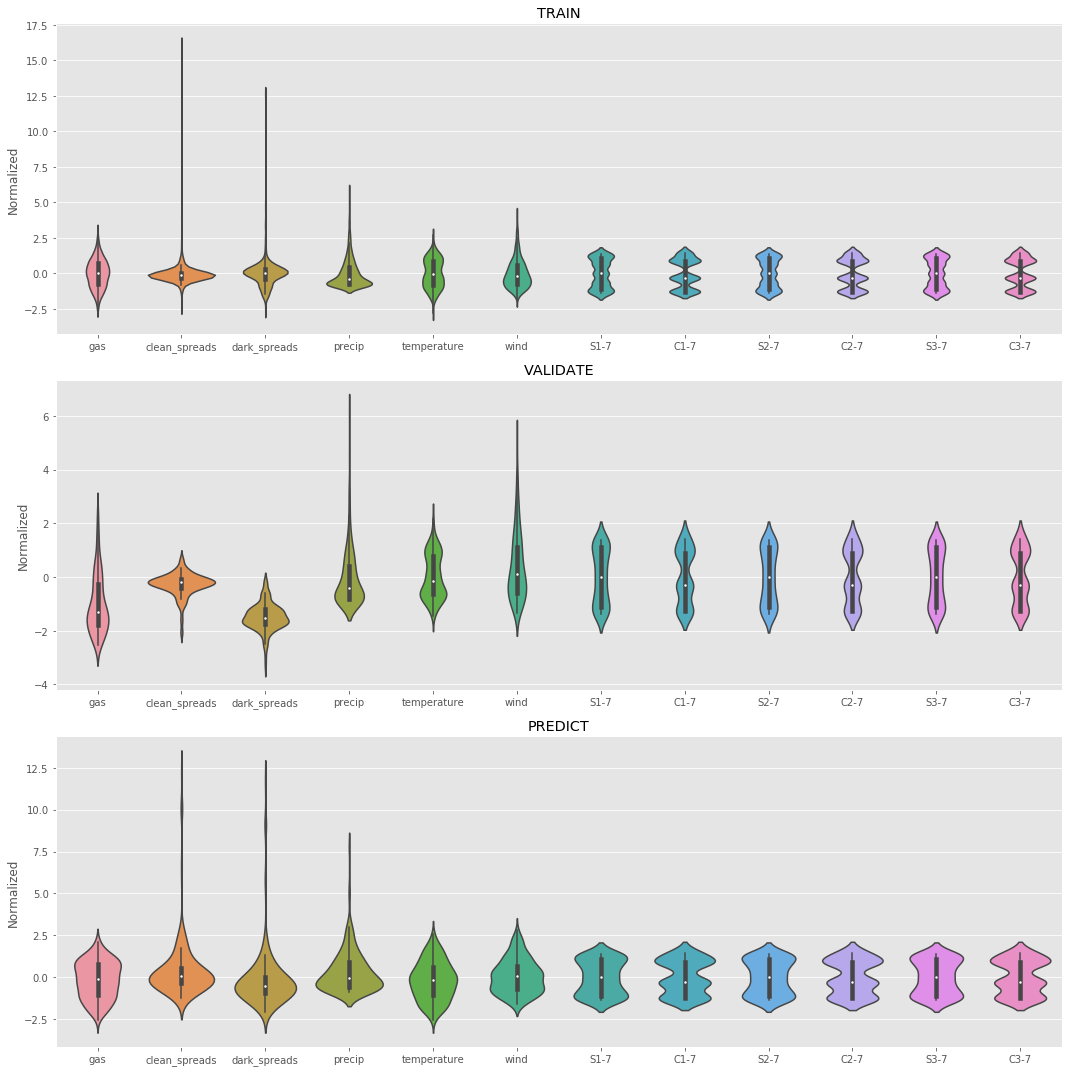

In [2419]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
_ = train_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax1)
_ = val_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax2)
_ = pred_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax3)
ax1.set_title('TRAIN')
ax2.set_title('VALIDATE')
ax3.set_title('PREDICT')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
plt.tight_layout()
plt.show()

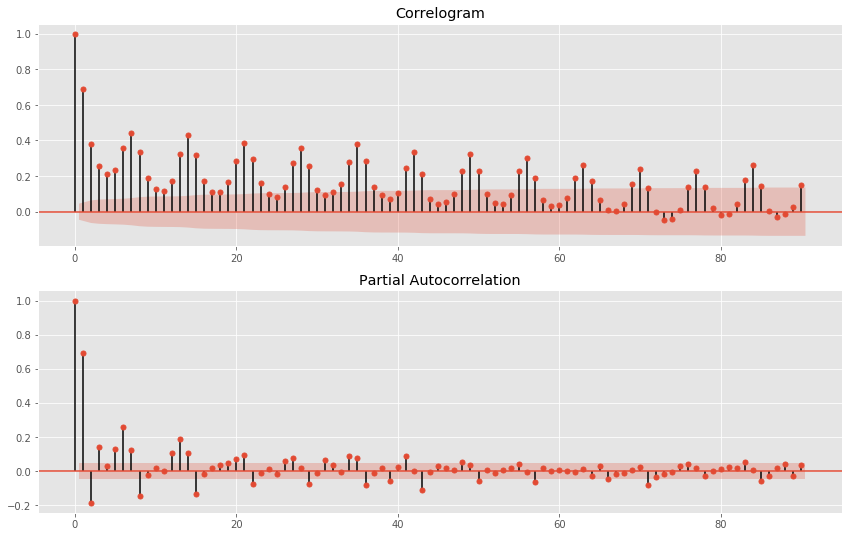

In [2420]:
stb.stat_plots.plot_acf_pcf(y, kwargs_acf=dict(lags=90), kwargs_pacf=dict(lags=90))

# WINDOWS GENERATOR

In [2421]:
train_df

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
day,,,,,,,,,,,,
2016-01-03,-0.799345,-0.259745,0.107476,2.419654,-0.613654,0.946639,1.104921e+00,0.882715,1.377814e+00,-0.313725,6.131847e-01,-1.273196
2016-01-04,0.033713,-0.034700,0.309247,1.647300,-0.713774,0.673097,1.377814e+00,-0.313725,-6.131847e-01,-1.273196,-1.104921e+00,0.882715
2016-01-05,0.482383,-0.059512,0.306953,1.272969,-0.709051,0.091820,6.131847e-01,-1.273196,-1.104921e+00,0.882715,1.377814e+00,-0.313725
2016-01-06,0.519504,-0.167764,0.269445,1.566748,-0.825228,-0.284300,-6.131847e-01,-1.273196,1.104921e+00,0.882715,-1.377814e+00,-0.313725
2016-01-07,0.047160,-0.109244,0.439420,0.813348,-0.893233,1.886939,-1.377814e+00,-0.313725,6.131847e-01,-1.273196,1.104921e+00,0.882715
2016-01-08,0.680397,-0.109244,0.439420,-0.347552,-1.171868,-0.480909,-1.104921e+00,0.882715,-1.377814e+00,-0.313725,-6.131847e-01,-1.273196
2016-01-09,-0.606312,-0.109244,0.439420,2.291718,-0.881899,0.416651,1.773615e-16,1.415182,-1.773111e-15,1.415182,-7.904738e-16,1.415182
2016-01-10,-0.856409,-0.174721,0.244084,1.381952,-1.030189,0.980831,1.104921e+00,0.882715,1.377814e+00,-0.313725,6.131847e-01,-1.273196
2016-01-11,0.847322,0.086629,0.528256,-0.129587,-1.216261,-0.557842,1.377814e+00,-0.313725,-6.131847e-01,-1.273196,-1.104921e+00,0.882715


In [2422]:
INP_W = 7*5
OUT_W = 7
BATC_S = 7
SHUFFLE = False

In [2423]:
print(f'INP_W={INP_W} OUT_W={OUT_W} BATC_S={BATC_S} SHUFFLE={SHUFFLE}')

INP_W=35 OUT_W=7 BATC_S=7 SHUFFLE=False


In [2424]:
window = stb.WindowGenerator(
                         input_width=INP_W,
                         label_width=OUT_W,
                         shift=OUT_W,
                         train_df=train_df,
                         val_df=None,
                         test_df=pred_df,
                         label_columns=['gas'])

In [2425]:
window

Total window size: 42
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Label indices: [35 36 37 38 39 40 41]
Label column name(s): ['gas']

In [2426]:
window.config(shuffle=SHUFFLE, batch_size=BATC_S)

{'targets': None, 'sequence_stride': 1, 'shuffle': False, 'batch_size': 7}


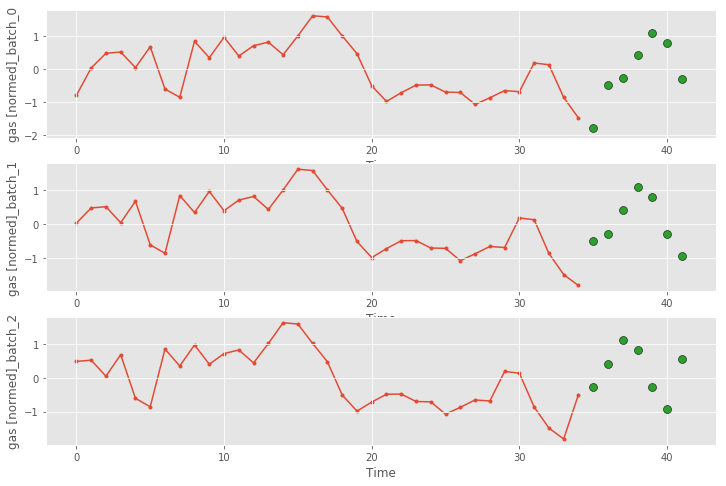

In [2427]:
window.plot('gas')

# Long Short Term Memory RNN

In [2428]:
lstm_model = tf.keras.models.Sequential([
    
    tf.keras.layers.LSTM(units=64, activation='relu',return_sequences=True),
    tf.keras.layers.LSTM(units=64, activation='relu',return_sequences=False),
    tf.keras.layers.Dense(units=OUT_W)
])

In [2429]:
print('Input shape (batch_size, input_days, num_features):', window.example[0].shape)
print('Output shape (batch_size, output_days):', lstm_model(window.example[0]).shape)

Input shape (batch_size, input_days, num_features): (7, 35, 12)
Output shape (batch_size, output_days): (7, 7)


In [2433]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=4, learning_rate=5e-3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(lr=learning_rate),
                metrics=[tf.metrics.MeanSquaredError()])

  history = model.fit(window.train, 
                      epochs=MAX_EPOCHS,
                      callbacks=[early_stopping])
  return history

In [2434]:
history = compile_and_fit(lstm_model,window)

Epoch 1/100
203/203 [==============================] - 5s 15ms/step - loss: 0.6536 - mean_squared_error: 0.6536
Epoch 2/100
203/203 [==============================] - 3s 15ms/step - loss: 0.5484 - mean_squared_error: 0.5484
Epoch 3/100
203/203 [==============================] - 4s 19ms/step - loss: 0.5133 - mean_squared_error: 0.5133
Epoch 4/100
203/203 [==============================] - 4s 20ms/step - loss: 0.4884 - mean_squared_error: 0.4884
Epoch 5/100
203/203 [==============================] - 4s 20ms/step - loss: 0.4899 - mean_squared_error: 0.4899
Epoch 6/100
203/203 [==============================] - 4s 19ms/step - loss: 0.4494 - mean_squared_error: 0.4494
Epoch 7/100
203/203 [==============================] - 4s 20ms/step - loss: 0.4254 - mean_squared_error: 0.4254
Epoch 8/100
203/203 [==============================] - 4s 20ms/step - loss: 0.4524 - mean_squared_error: 0.4524
Epoch 9/100
203/203 [==============================] - 4s 19ms/step - loss: 0.4178 - mean_squared_error:

2021-04-07 10:32:03,927: tensorflow: 126: WARNING: 5 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001CDEE9D0168> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details..


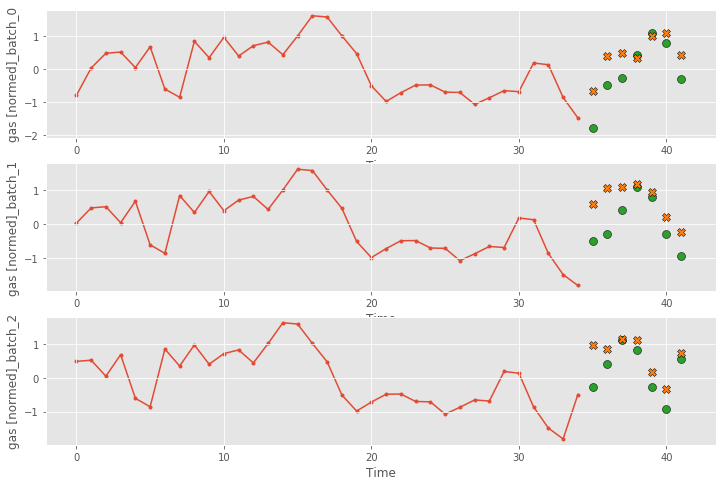

In [2435]:
res = window.plot('gas', model=lstm_model)

In [2436]:
w_pred = stb.WindowGenerator(
            input_width=INP_W,
            label_width=0,
            shift=0,
            train_df=pred_df.head(INP_W),
            val_df=None,
            test_df=None,
            label_columns=['gas'])

w_pred.config(shuffle=False, batch_size=1)

{'targets': None, 'sequence_stride': 1, 'shuffle': False, 'batch_size': 1}


In [2437]:
fl(lstm_model.predict(w_pred.train))

2021-04-07 10:32:09,319: tensorflow: 126: WARNING: 5 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001CDEE9D0168> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details..


[0.73541176,
 0.5023734,
 -0.4710735,
 -1.0676914,
 -0.499801,
 0.301683,
 0.20432423]

In [2438]:
fl = stb.utils.common.flatten_lst

In [2439]:
idx = pred_df.shift(INP_W).dropna().head(OUT_W).index; idx

DatetimeIndex(['2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05',
               '2020-09-06', '2020-09-07', '2020-09-08'],
              dtype='datetime64[ns]', name='day', freq=None)

In [2440]:
predicted = fl(lstm_model.predict(w_pred.train)); predicted

[0.73541176,
 0.5023734,
 -0.4710735,
 -1.0676914,
 -0.499801,
 0.301683,
 0.20432423]

In [2441]:
v_hat = pd.Series(predicted, index=idx); v_hat

day
2020-09-02    0.735412
2020-09-03    0.502373
2020-09-04   -0.471074
2020-09-05   -1.067691
2020-09-06   -0.499801
2020-09-07    0.301683
2020-09-08    0.204324
dtype: float64

In [2442]:
v = pred_df.loc[idx]['gas']; v

day
2020-09-02   -0.414930
2020-09-03   -0.866770
2020-09-04   -1.113259
2020-09-05   -1.446539
2020-09-06    0.144032
2020-09-07   -0.449539
2020-09-08    0.012119
Name: gas, dtype: float64

In [2443]:
y_hat = v_hat*train_std['gas']+train_mean['gas']; y_hat

day
2020-09-02    64.178688
2020-09-03    60.906463
2020-09-04    47.237741
2020-09-05    38.860290
2020-09-06    46.834362
2020-09-07    58.088455
2020-09-08    56.721385
dtype: float64

In [2444]:
y = DM.dm.loc[y_hat.index]['y']; y

day
2020-09-02    48.026086
2020-09-03    41.681535
2020-09-04    38.220445
2020-09-05    33.540682
2020-09-06    55.874794
2020-09-07    47.540126
2020-09-08    54.022522
Name: y, dtype: float64

In [2445]:
print(f'Error={stb.metrics.root_mean_squared_error(y, y_hat):.4f}')

Error=11.5906


In [2446]:
metric = stb.metrics.root_mean_squared_error

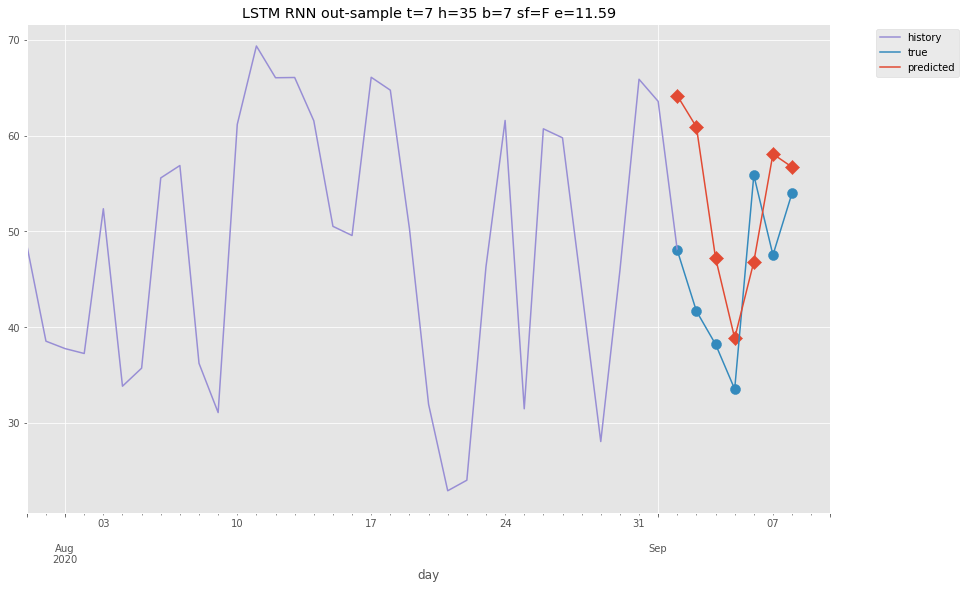

In [2447]:
out_of_sample_error = metric(y, y_hat)

fig, ax =plt.subplots(figsize=figsize)
DM.dm.truncate(after=y_hat.index.min()).iloc[-int(INP_W):]['v'].plot(ax=ax, 
                                        color=stb.utils.plots.get_standard_colors()[2])
y.plot(ax=ax, color=stb.utils.plots.get_standard_colors()[1])
y_hat.plot(ax=ax, color=stb.utils.plots.get_standard_colors()[0])

ax.scatter(y.index, y.values, 100, color=stb.utils.plots.get_standard_colors()[1])
ax.scatter(y_hat.index, y_hat.values, 100, marker='D', color=stb.utils.plots.get_standard_colors()[0])


ax.legend(['history', 'true', 'predicted'], bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlim(right=y.index.max() + DateOffset(days=2))

plt.title(f'ForecastHorizon={OUT_W}days | Error={stb.metrics.root_mean_squared_error(y, y_hat):.4f}')
title = f'LSTM RNN out-sample t={OUT_W} h={INP_W} b={BATC_S} sf={str(SHUFFLE)[0]} e={out_of_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()